#Assignment 2 - Semantic Segmentation in Underwater Imagery

In [ ]:
# Load the SUIM folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!unzip -q "/content/drive/MyDrive/SUIM.zip" -d "/content/SUIM"

Mounted at /content/drive
mapname:  conversion of  failed
replace /content/SUIM/INFO.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import numpy as np
import torchvision
import torch.nn as nn

Imagem encontrada: w_r_102_.jpg


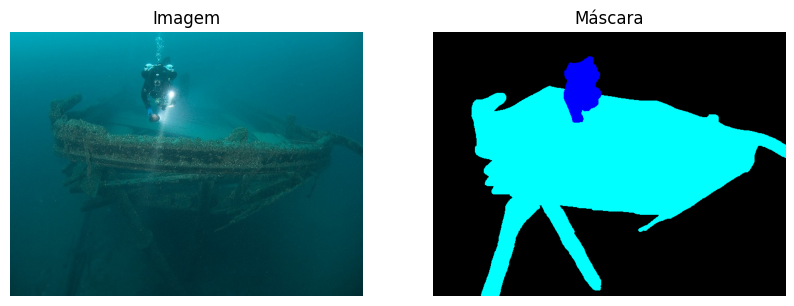

Imagem encontrada: f_r_1719_.jpg


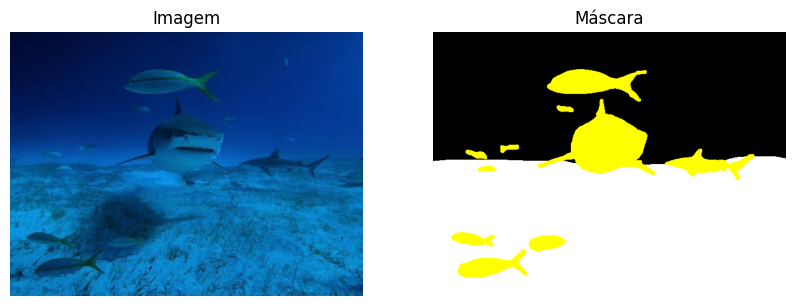

Imagem encontrada: f_r_979_.jpg


KeyboardInterrupt: 

In [ ]:
images_folder = '/content/SUIM/train_val/images'
mask_folder = '/content/SUIM/train_val/masks'

image_files = [f for f in os.listdir(images_folder) if f.lower().endswith('.jpg')]
for file in image_files:
  if file.lower().endswith(('.jpg')):

    image_path = os.path.join(images_folder, file) #finds the images
    mask_path = os.path.join(mask_folder, file.replace('.jpg', '.bmp')) #finds the masks in the same order as the images

    print("Imagem encontrada:", file)
    if not os.path.exists(image_path):
      continue
    img = Image.open(image_path)
    mask = Image.open(mask_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[0].set_title("Imagem")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Máscara")
    axes[1].axis('off')

    plt.show()

#Color Map

In [ ]:
COLOR_MAP = {
  (0, 0, 0): 0,     # Background
  (0, 0, 255): 1,   # Human body
  (0, 255, 0): 2,   # Fish
  (255, 0, 0): 3,   # Robots / vehicles
  (255, 255, 0): 4, # Rocks
  (0, 255, 255): 5, # Plants
  (255, 0, 255): 6, # Wrecks
  (255, 255, 255): 7 # Unknown/other
}

INDEX_TO_COLOR = {
  0: (0, 0, 0),
  1: (0, 0, 255),
  2: (0, 255, 0),
  3: (255, 0, 0),
  4: (255, 255, 0),
  5: (0, 255, 255),
  6: (255, 0, 255),
  7: (255, 255, 255)
}

#Transform

In [ ]:
# make the images the same size
transform_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST) #480,640
])

#Custom Dataset

In [ ]:
class SegmentationDataset(Dataset):
    # useful methods for the dataset
    def __init__(self, images_folder, masks_folder, transform_img=None, transform_mask=None):
        self.images_folder = images_folder
        self.masks_folder = masks_folder

        self.transform_img = transform_img
        self.transform_mask = transform_mask

        # List all images
        self.image_files = sorted(
            [f for f in os.listdir(images_folder) if f.lower().endswith(".jpg")]
        )

    # this method gets the RGB mask and converts it into a 2D matrix of class IDs (each pixel has the class number)
    def rgb_to_class(self, mask):
        mask_np = np.array(mask)
        class_mask = np.zeros(mask_np.shape[:2], dtype=np.int64)

        for rgb, class_id in COLOR_MAP.items():
            matches = np.all(mask_np == rgb, axis=-1)
            class_mask[matches] = class_id

        return class_mask

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]

        img_path = os.path.join(self.images_folder, img_name)
        mask_path = os.path.join(self.masks_folder, img_name.replace(".jpg", ".bmp"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        # Apply transforms separately
        if self.transform_img:
            image = self.transform_img(image)
        else:
            image = transforms.ToTensor()(image)

        if self.transform_mask:
            mask = self.transform_mask(mask)

        # Convert RGB mask → class index mask
        mask = self.rgb_to_class(mask)
        mask = torch.tensor(mask, dtype=torch.long)
        # tensor é um vetor (N-dimensional list) usados para as neural networks pq é melhor

        return image, mask


In [ ]:
def class_to_rgb(class_mask):
    h, w = class_mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)

    for cls, color in INDEX_TO_COLOR.items():
        rgb[class_mask == cls] = color

    return rgb

#DataLoaders

In [ ]:
from torch.utils.data import random_split

images_folder = '/content/SUIM/train_val/images'
masks_folder = '/content/SUIM/train_val/masks'
#creates the dataset
dataset = SegmentationDataset(images_folder, masks_folder,transform_img,transform_mask)

# dividir treino/val (80% treino, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
#creates a dataloader (groups of 4 mini-batches for GPU)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

#Segmentation Model

In [ ]:
model = torchvision.models.segmentation.fcn_resnet50(
    weights="DEFAULT",     # Pretrained backbone + segmentation head
)

# Replace the final classifier layer to match your number of classes
model.classifier[4] = nn.Conv2d(512, 8, kernel_size=1)

#Training

In [ ]:
#chooses GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#loss function
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5  # só para teste
#training loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        unique_vals = torch.unique(masks)
        print(unique_vals)
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        print(images.shape, masks.shape)
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])


In [ ]:
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)

        break  # show one batch

NameError: name 'model' is not defined

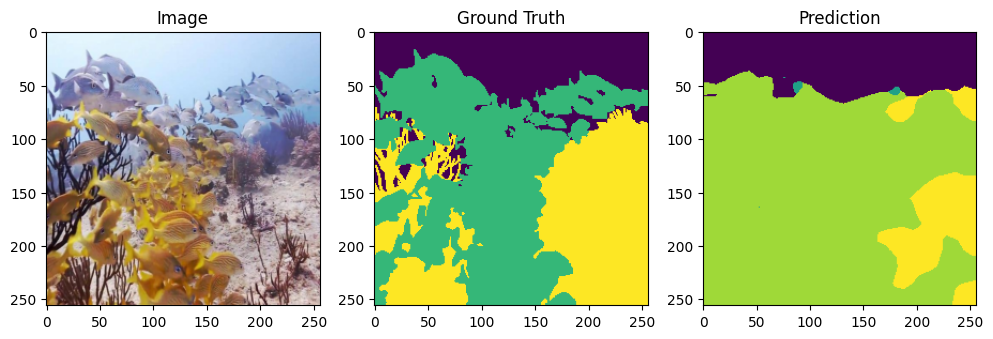

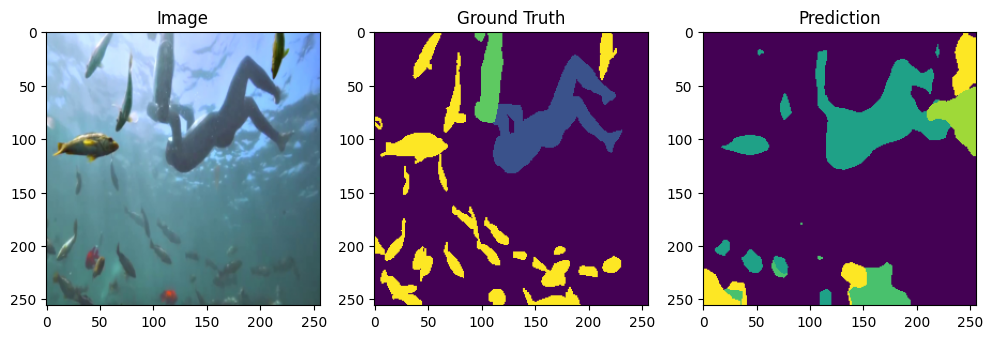

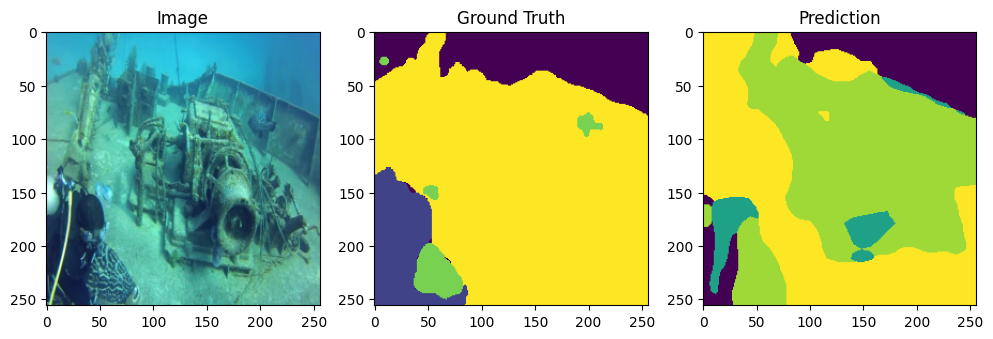

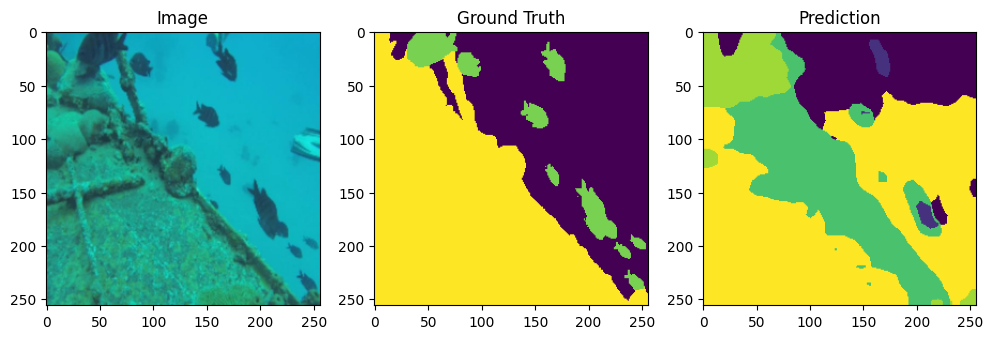

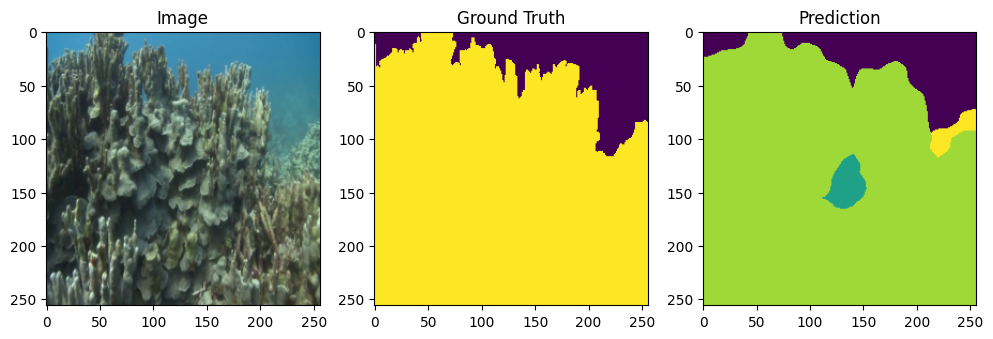

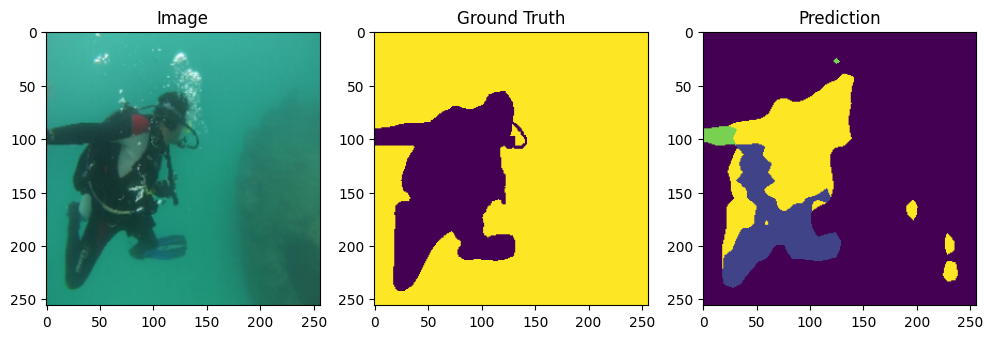

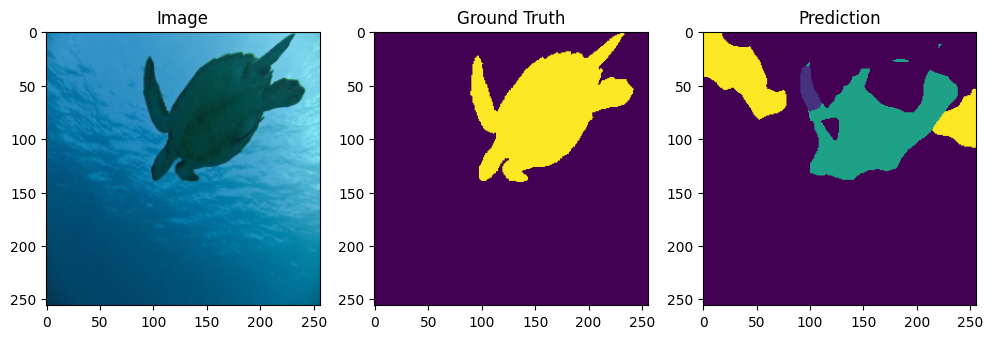

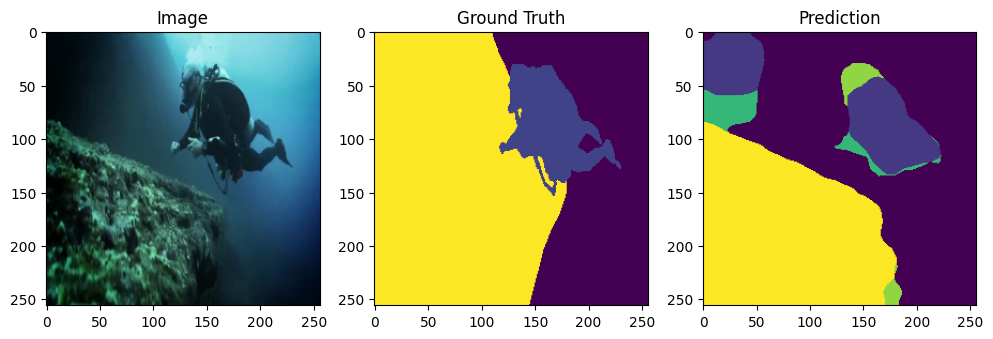

In [ ]:
for batch_idx, (images, masks) in enumerate(train_loader):
  preds = model(images.to(device))['out'].argmax(1)
  for i in range (images.size(0)):
    img = images[i].cpu().permute(1,2,0)
    true_mask = masks[i].cpu().numpy()
    pred_mask = preds[i].cpu().numpy()

    true_mask_rgb = class_to_rgb(true_mask)
    pred_mask_rgb = class_to_rgb(pred_mask)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(true_mask_rgb)
    plt.title("Ground Truth")

    plt.subplot(1,3,3)
    plt.imshow(pred_mask_rgb)
    plt.title("Prediction")

    plt.show()